# Trial to Paid Classification Hyperparameter Tuning
The objectvie of this machine learning project was to help a CRM company's marketing team to identify customers that are likely to convert from trial subsciption plan to paying subscription plan. To tackle the challenge, I developed a binary classification model with AWS SageMaker that predicts whether a customer converts to paying subscription plan.

In this notebook, I am performing a hyperparameter tuning job on base model.

Note: datasets for this project are not publicly available.

In [4]:
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

user = '<USERNAME>'
base_bucket = '<BUCKETNAME>'
prefix = f'''{user}/sagemaker/lab01/trial_to_paid'''

if not user:
    raise NameError('Forgot to fill in user varaible')

dataset_path = f'''s3://{base_bucket}/{prefix}/input/dataset.csv'''
train_path   = f'''s3://{base_bucket}/{prefix}/input/train.csv'''
test_path    = f'''s3://{base_bucket}/{prefix}/input/test.csv'''

In [5]:
# Attatching column names with training data
columns = ['flag_converted', 'total_users',
       'typ_event_activity_added', 'segment_veroemail_opened',
       'typ_event_person_added', 'segment_stage_added',
       'typ_event_pipeline_view_opened', 'segment_veroemail_unsubscribed',
       'segment_stage_updated', 'typ_event_email_sent', 'typ_event_deal_added',
       'segment_user_logged_in', 'typ_event_deal_won',
       'typ_events_overall_activity', 'typ_event_lead_added', 'unique_users',
       'vistis', 'avg_lenght_seconds', 'blogpageload_count',
       'wwwpageload_count', 'apppageload_count', 'webapppageload_count',
       'supportpageload_count', 'flag_promocode_no', 'flag_promocode_yes',
       'billingdetails_entered_no', 'billingdetails_entered_yes',
       'key_country_AU', 'key_country_BR', 'key_country_CA', 'key_country_CL',
       'key_country_DE', 'key_country_EE', 'key_country_ES', 'key_country_FR',
       'key_country_GB', 'key_country_IN', 'key_country_MX', 'key_country_NL',
       'key_country_PL', 'key_country_RU', 'key_country_US', 'key_country_ZA',
       'key_country_other', 'day_name_of_week_Friday',
       'day_name_of_week_Monday', 'day_name_of_week_Saturday',
       'day_name_of_week_Sunday', 'day_name_of_week_Thursday',
       'day_name_of_week_Tuesday', 'day_name_of_week_Wednesday',
       'industry_construction', 'industry_consulting',
       'industry_creative agency (web, advertising, video)',
       'industry_education and training',
       'industry_financial or credit services', 'industry_health',
       'industry_it services', 'industry_manufacturing',
       'industry_news, media and publications', 'industry_not inserted',
       'industry_other', 'industry_real estate',
       'industry_software, app development', 'industry_tech startup',
       'industry_trade (retail, wholesale)', 'email_domain_disposable_domain',
       'email_domain_private_domain', 'email_domain_public_email_domain',
       'flag_clearbit_success_0', 'flag_clearbit_success_1',
       'typ_flag_search_0', 'typ_flag_search_1', 'typ_flag_billing_0',
       'typ_flag_billing_1', 'typ_flag_pipeline_customization_0',
       'typ_flag_pipeline_customization_1',
       'typ_flag_organization_details_opened_0',
       'typ_flag_organization_details_opened_1', 'typ_flag_filters_0',
       'typ_flag_filters_1', 'typ_flag_deal_list_opened_0',
       'typ_flag_deal_list_opened_1', 'typ_flag_calendar_sync_enabled_0',
       'typ_flag_calendar_sync_enabled_1', 'typ_flag_activity_list_opened_0',
       'typ_flag_activity_list_opened_1', 'typ_flag_lead_details_opened_0',
       'typ_flag_lead_details_opened_1', 'typ_flag_import_0',
       'typ_flag_import_1', 'typ_flag_insights_0', 'typ_flag_insights_1',
       'typ_flag_email_sync_enabled_0', 'typ_flag_email_sync_enabled_1',
       'typ_flag_custom_fields_0', 'typ_flag_custom_fields_1']


train = pd.read_csv(train_path, names=columns)

train.shape

(78302, 97)

In [3]:
from sagemaker import image_uris, get_execution_role
from sagemaker.session import Session
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import HyperparameterTuner
from sagemaker.tuner import ContinuousParameter, IntegerParameter
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

In [4]:
# Initialising hyperparameters
hyperparameters = {
    'max_depth': '6',
    'num_round': '80',
    'objective': 'binary:logistic',
    'eval_metric': 'auc' #'eval_metric': 'auc,aucpr,error,map,accuracy'
}

# Setting an output path where the trained model will be saved
output_path = f'''s3://{base_bucket}/{prefix}/output'''
region = 'eu-central-1'
content_type = 'csv'
save_interval = 5

xgboost_container = image_uris.retrieve('xgboost', region, '1.2-1')


rules=[
    Rule.sagemaker(rule_configs.create_xgboost_report())
]

# Constructing a SageMaker estimator that calls the xgboost-container
estimator = Estimator(image_uri=xgboost_container, 
                      hyperparameters=hyperparameters,
                      role=get_execution_role(),
                      instance_count=1, 
                      instance_type='ml.m5.xlarge', 
                      volume_size=10, # 10 GB,
                      use_spot_instances=True,
                      max_wait=3600, # Needed when using spot instances, timeout in seconds
                      max_run=3600,
                      output_path=output_path,
                      rules=rules
                     )
# Defining the data type and paths to the training and validation datasets
train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(test_path, content_type=content_type)

In [5]:
# Setting up hyperparameter ranges and defining hyperparameter tuner
hyperparameter_ranges = {
    'eta': ContinuousParameter(0, 1),
    'min_child_weight': ContinuousParameter(1, 10),
    'alpha': ContinuousParameter(0, 2),
    'max_depth': IntegerParameter(1, 10),
    'num_round': IntegerParameter(1, 300)
}


tuner = HyperparameterTuner(estimator=estimator, 
                            base_tuning_job_name='sg-lab01',
                            objective_metric_name='validation:auc',
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=2, 
                            max_parallel_jobs=1)

# Executing the XGBoost Tunining job
tuner.fit({'train': train_input, 'validation': validation_input},  include_cls_metadata=False)
tuner.wait()

..........................................................................................!
!


In [7]:
tuner.best_training_job()

'sg-lab01-210616-1305-002-dd89e443'

In [8]:
# Analysing tuner training jobs
tuner.analytics().dataframe()

,alpha,eta,max_depth,min_child_weight,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.165279,0.789479,8.0,2.111280,1.0,sg-lab01-210616-1305-002-dd89e443,Completed,0.85323,2021-06-16 13:11:56+00:00,2021-06-16 13:13:02+00:00,66.0
1,0.983375,0.532531,7.0,3.604234,1.0,sg-lab01-210616-1305-001-198c702d,Completed,0.84749,2021-06-16 13:08:12+00:00,2021-06-16 13:09:20+00:00,68.0


In [9]:
# Attaching best job name too tuner and creating a model with best hyperparameters
tuner = HyperparameterTuner.attach('sg-lab01-210311-2030') 
best_estimator = tuner.best_estimator() 


2021-03-11 20:43:53 Starting - Preparing the instances for training
2021-03-11 20:43:53 Downloading - Downloading input data
2021-03-11 20:43:53 Training - Training image download completed. Training in progress.
2021-03-11 20:43:53 Uploading - Uploading generated training model
2021-03-11 20:43:53 Completed - Training job completed


### Training best model

In [10]:
# Training model with best hyperparameters
estimator.fit({'train': train_input, 'validation': validation_input})

2021-06-16 13:13:34 Starting - Starting the training job...
2021-06-16 13:13:57 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1623849214: InProgress
...
2021-06-16 13:14:31 Starting - Insufficient capacity error from EC2 while launching instances, retrying!......
2021-06-16 13:15:31 Starting - Preparing the instances for training......
2021-06-16 13:16:31 Downloading - Downloading input data...
2021-06-16 13:16:57 Training - Downloading the training image..[2021-06-16 13:17:17.952 ip-10-0-220-100.eu-central-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (no

In [11]:
debug_report = estimator.latest_job_debugger_artifacts_path()

### Manually setting debug configs and rules 

In [14]:
# Constructing model 
estimator = Estimator(image_uri=xgboost_container, 
                      hyperparameters=hyperparameters,
                      role=get_execution_role(),
                      instance_count=1, 
                      instance_type='ml.m5.xlarge', 
                      volume_size=10, # 10 GB,
                      use_spot_instances=True,
                      max_wait=3600, # Needed when using spot instances, timeout in seconds
                      max_run=3600,
                      output_path=output_path,
                      debugger_hook_config=DebuggerHookConfig(
                          s3_output_path=f'''{output_path}/debugger''',
                          collection_configs=[
                              CollectionConfig(
                                  name='metrics',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              ),
                              CollectionConfig(
                                  name='feature_importance',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              ),
                             CollectionConfig(
                                  name='full_shap',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              ),
                              CollectionConfig(
                                  name='average_shap',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              )
                          ]
                      ),
                      rules=[
                            Rule.sagemaker(
                                rule_configs.loss_not_decreasing(),
                                rule_parameters={
                                    'collection_names': 'metrics',
                                    'num_steps': str(save_interval * 2),
                                },
                            ),
                        ]
                     )
train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(test_path, content_type=content_type)

estimator.fit({'train': train_input, 'validation': validation_input})

2021-06-16 13:18:18 Starting - Starting the training job...
2021-06-16 13:18:42 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
ProfilerReport-1623849498: InProgress
...
2021-06-16 13:19:02 Starting - Insufficient capacity error from EC2 while launching instances, retrying!...
2021-06-16 13:19:47 Starting - Preparing the instances for training......
2021-06-16 13:20:44 Downloading - Downloading input data...
2021-06-16 13:21:04 Training - Downloading the training image...
2021-06-16 13:21:44 Training - Training image download completed. Training in progress.[2021-06-16 13:21:35.706 ip-10-0-192-87.eu-central-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic

In [15]:
# Retreiving model training job artifacts from S3
from smdebug.trials import create_trial

s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-06-16 13:32:39.020 ip-172-16-27-61:23479 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-16 13:32:39.034 ip-172-16-27-61:23479 INFO s3_trial.py:42] Loading trial debug-output at path s3://pdw-users/kristofer_siimar/sagemaker/lab01/trial_to_paid/output/debugger/sagemaker-xgboost-2021-06-16-13-18-18-176/debug-output


In [18]:
import shap
from itertools import islice
import matplotlib.pyplot as plt

import re


feature_names = list(train.columns)
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = (trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

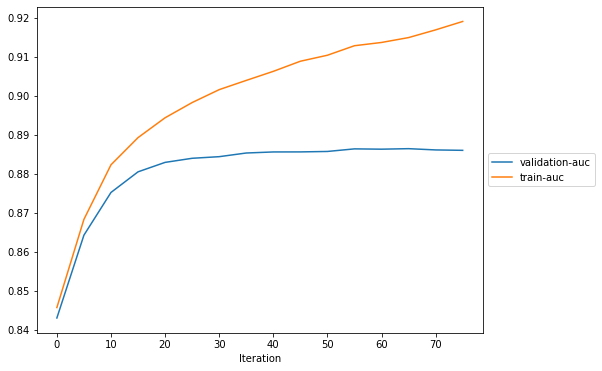

In [21]:
# Visualising roc auc score performance throughout training and validation job
plot_collection(trial, "metrics")

In [22]:
# Defining function that plots feature importances
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(
            f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

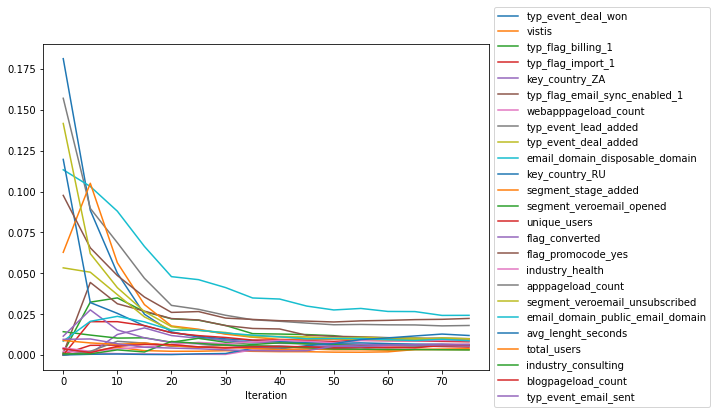

In [24]:
plot_feature_importance(trial, importance_type="cover")

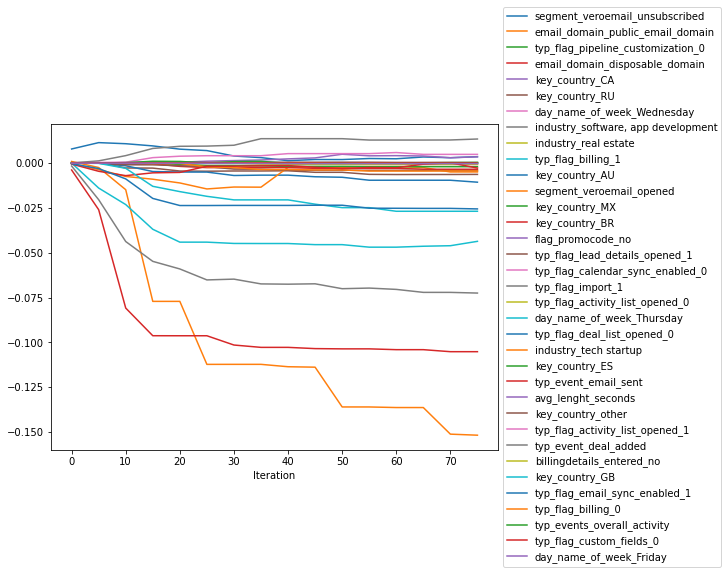

In [26]:
plot_collection(trial, "average_shap")

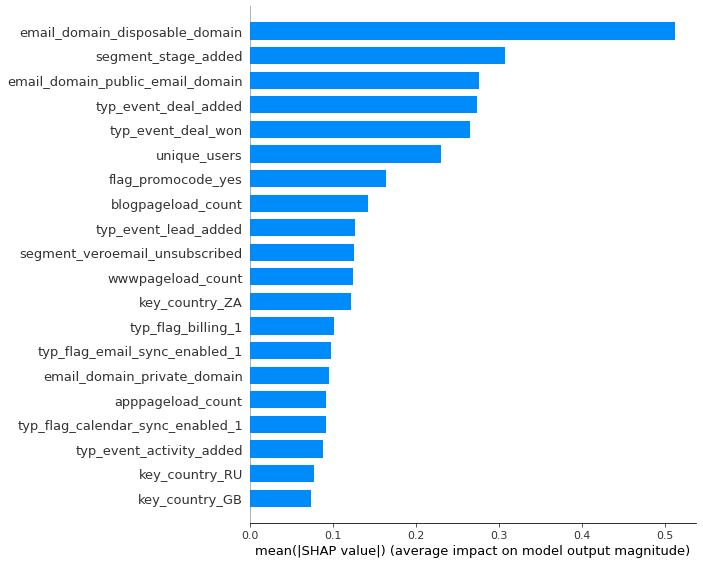

In [27]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

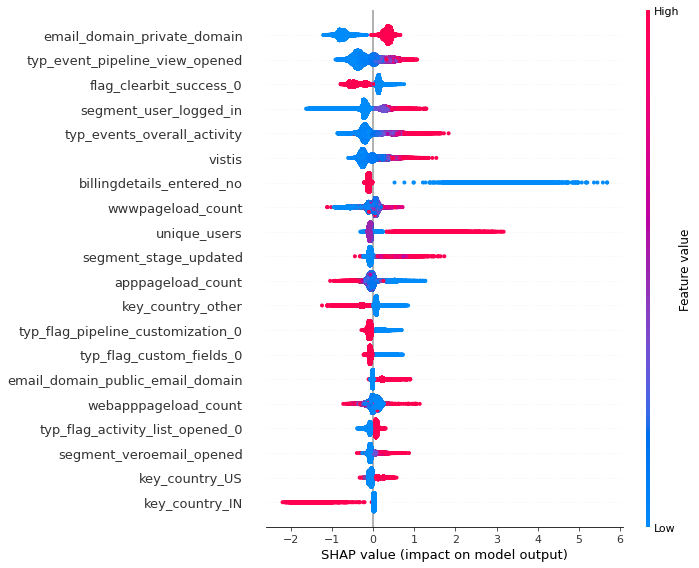

In [79]:
shap.summary_plot(shap_no_base, train.iloc[:, 1:])